In [10]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if your notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

#================================================================
# Imports custom preprocessing functions from 'functions.py'
#================================================================

from lib.functions import (is_binary_like,
                           _pretty_p,
                           evaluate_classifier,
                           iqr_bounds,
                           quick_outlier_scan,
                           drop_outliers_iqr
                           )

#================================================================
#  Initialize config
#================================================================
config = None
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")
    
# =============================================================================
# DATA LOADING
# =============================================================================
df = pd.read_csv(config['input_data']['file1'])

# =============================================================================
# Set visualization style
# =============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
# Custom color palettes - choose one or mix them
blue_palette = sns.color_palette("Blues_r", n_colors=8)
green_palette = sns.color_palette("Greens_r", n_colors=8)
orange_palette = sns.color_palette("Oranges_r", n_colors=8)
# Set a blue-green palette as default
sns.set_palette("viridis")

## Comprehensive Analysis of Stress Level Dataset for Machine Learning

In [11]:
# =============================================================================
# 1. INITIAL DATA EXPLORATION
# =============================================================================

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")
print("\nColumn Names:")
print(df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Display unique values
print("\nUnique values per column:")
display(df.nunique())

DATASET OVERVIEW
Dataset Shape: (1100, 21)
Total Records: 1100
Total Features: 21

Column Names:
['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']

First 5 rows of the dataset:


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1



Unique values per column:


anxiety_level                   22
self_esteem                     31
mental_health_history            2
depression                      28
headache                         6
blood_pressure                   3
sleep_quality                    6
breathing_problem                6
noise_level                      6
living_conditions                6
safety                           6
basic_needs                      6
academic_performance             6
study_load                       6
teacher_student_relationship     6
future_career_concerns           6
social_support                   4
peer_pressure                    6
extracurricular_activities       6
bullying                         6
stress_level                     3
dtype: int64

In [12]:
# =============================================================================
# 2. DATA QUALITY ASSESSMENT
# =============================================================================

print("\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found in the dataset!")
else:
    print(missing_values[missing_values > 0])

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Basic statistics
print("\nBasic Statistics:")
display(df.describe())


DATA QUALITY ASSESSMENT

Data Types:
anxiety_level                   int64
self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
future_career_concerns          int64
social_support                  int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object

Missing Values:
No missing values found in the dataset!

Duplicate Rows: 0

Basic Statistics:


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,11.063636,17.777273,0.492727,12.555455,2.508182,2.181818,2.660000,2.753636,2.649091,2.518182,...,2.772727,2.772727,2.621818,2.648182,2.649091,1.881818,2.734545,2.767273,2.617273,0.996364
std,6.117558,8.944599,0.500175,7.727008,1.409356,0.833575,1.548383,1.400713,1.328127,1.119208,...,1.433761,1.414594,1.315781,1.384579,1.529375,1.047826,1.425265,1.417562,1.530958,0.821673
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,11.000000,0.000000,6.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,11.000000,19.000000,0.000000,12.000000,3.000000,2.000000,2.500000,3.000000,3.000000,2.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.500000,3.000000,1.000000
75%,16.000000,26.000000,1.000000,19.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,...,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,2.000000
max,21.000000,30.000000,1.000000,27.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,2.000000


> **Insight:** Dataset has 1100 rows, 21 features, no missing values, and 0 duplicates — ready for analysis.


UNIVARIATE ANALYSIS


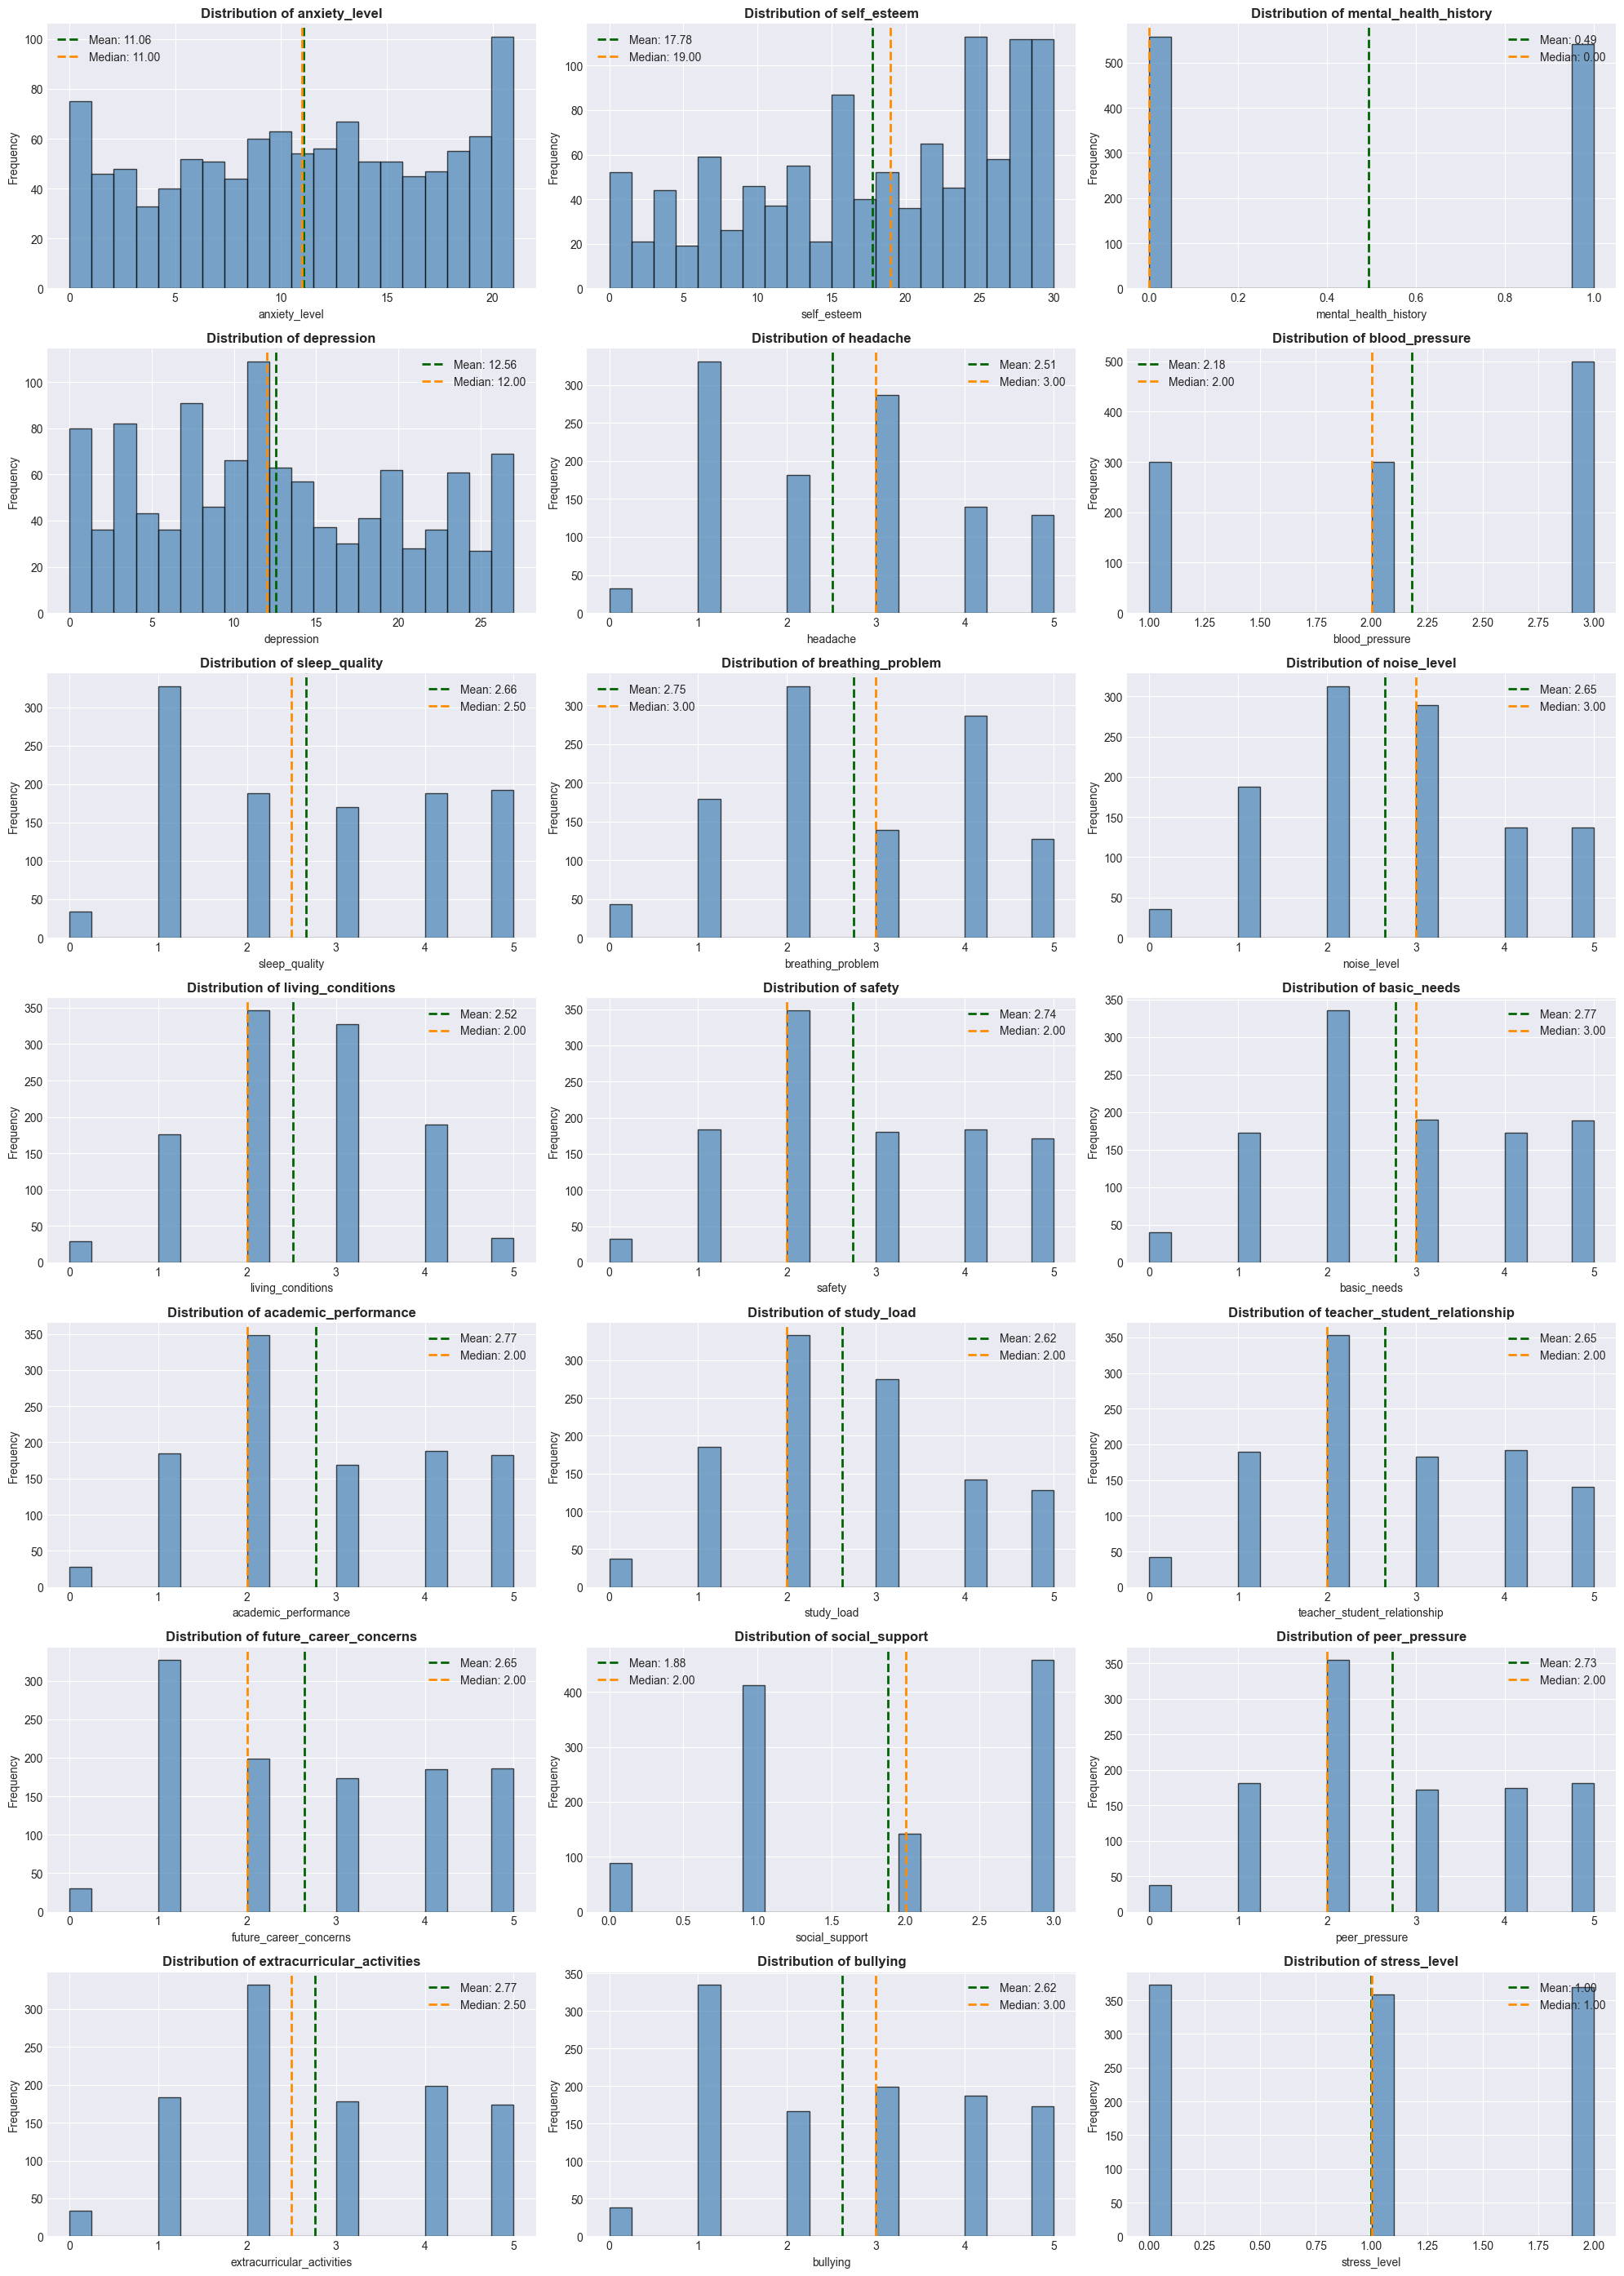


Skewness of Features:
headache                        0.270494
study_load                      0.228964
depression                      0.216638
noise_level                     0.207122
future_career_concerns          0.204276
teacher_student_relationship    0.198016
peer_pressure                   0.194719
safety                          0.188097
academic_performance            0.184316
sleep_quality                   0.177975
bullying                        0.175348
basic_needs                     0.135859
extracurricular_activities      0.135604
mental_health_history           0.029134
living_conditions               0.018794
stress_level                    0.006728
breathing_problem              -0.001625
anxiety_level                  -0.082612
social_support                 -0.180958
blood_pressure                 -0.351186
self_esteem                    -0.396539
dtype: float64


In [13]:
# =============================================================================
# 3. UNIVARIATE ANALYSIS - DISTRIBUTION OF FEATURES
# =============================================================================

print("\n" + "=" * 80)
print("UNIVARIATE ANALYSIS")
print("=" * 80)

# Create subplots for all features
fig, axes = plt.subplots(7, 3, figsize=(20, 28))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    # Use different shades of blue for histograms
    axes[idx].hist(df[col], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='darkorange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.savefig(config['output_data']['fig1'], dpi=300, bbox_inches='tight')    # savefig('feature_distributions.png')
plt.show()

# Check for skewness
print("\nSkewness of Features:")
skewness = df.skew()
print(skewness.sort_values(ascending=False))

> **Insight:** Distributions indicate **mild right-skew** in **headache, study_load, depression, noise_level, future_career_concerns** and **mild left-skew** in **self_esteem, blood_pressure, social_support**. Skews are generally small, so no transform is strictly required.


TARGET VARIABLE ANALYSIS (stress_level)


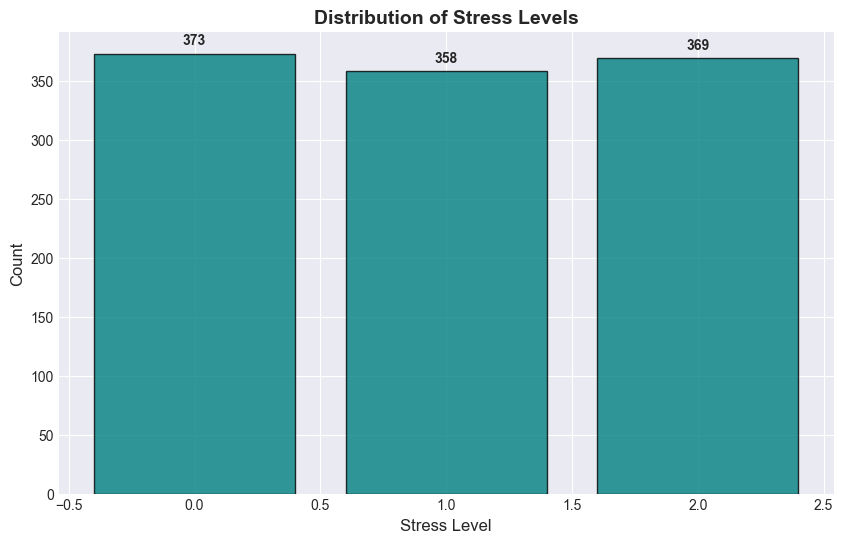


Stress Level Value Counts:
stress_level
0    373
1    358
2    369
Name: count, dtype: int64

Percentage Distribution:
stress_level
0    33.91
1    32.55
2    33.55
Name: count, dtype: float64


In [14]:
# =============================================================================
# 4. TARGET VARIABLE ANALYSIS
# =============================================================================

print("\n" + "=" * 80)
print("TARGET VARIABLE ANALYSIS (stress_level)")
print("=" * 80)

# Stress level distribution
plt.figure(figsize=(10, 6))
stress_counts = df['stress_level'].value_counts().sort_index()
bars = plt.bar(stress_counts.index, stress_counts.values, edgecolor='black', color='teal', alpha=0.8)
plt.xlabel('Stress Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Stress Levels', fontsize=14, fontweight='bold')
# Add value labels on bars
for i, v in enumerate(stress_counts.values):
    plt.text(stress_counts.index[i], v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.savefig(config['output_data']['fig2'], dpi=300, bbox_inches='tight')    # savefig('stress_level_distribution.png')
plt.show()

print("\nStress Level Value Counts:")
print(stress_counts)
print(f"\nPercentage Distribution:")
print((stress_counts / len(df) * 100).round(2))

> **Insight:** Target is roughly balanced across classes (0: 373, 1: 358, 2: 369), so standard stratified splits and macro‑averaged metrics are appropriate


CORRELATION ANALYSIS


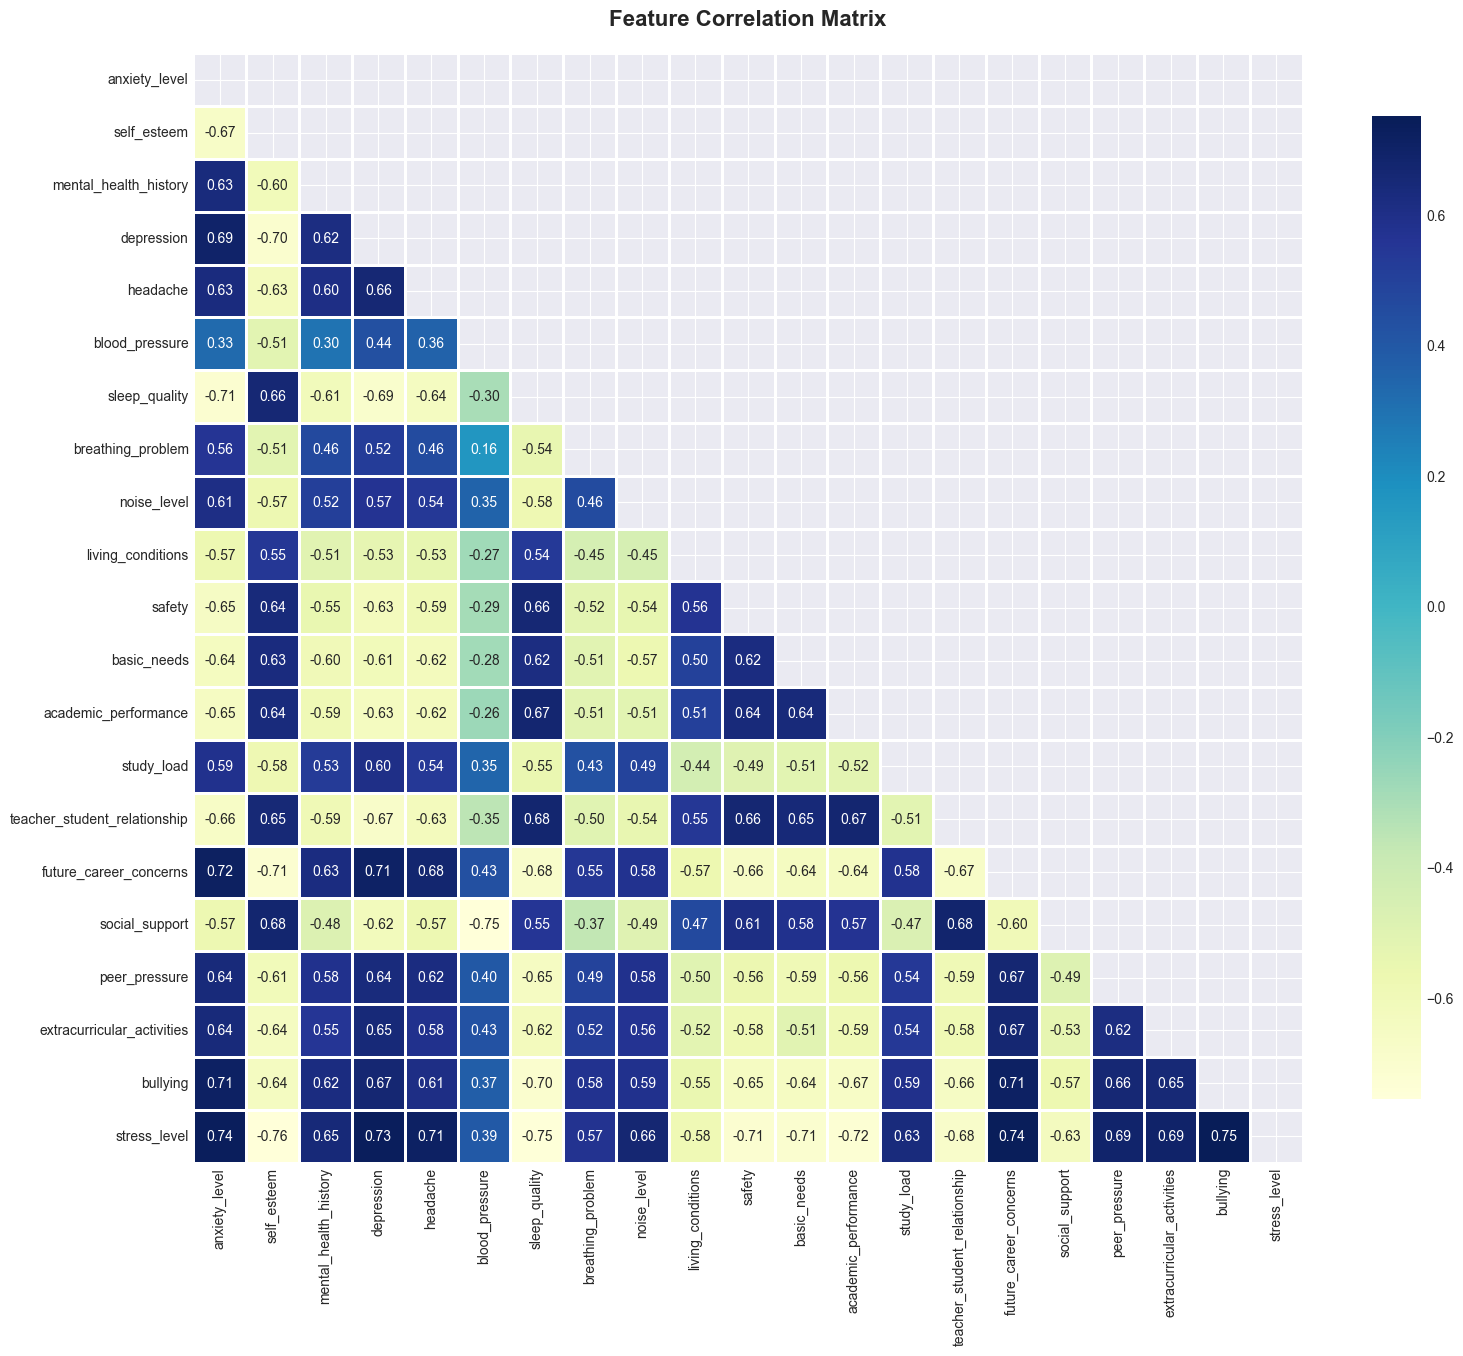


Top 10 Features Correlated with Stress Level:
bullying                      0.751162
future_career_concerns        0.742619
anxiety_level                 0.736795
depression                    0.734379
headache                      0.713484
extracurricular_activities    0.692977
peer_pressure                 0.690684
noise_level                   0.663371
mental_health_history         0.648644
study_load                    0.634156
Name: stress_level, dtype: float64

Bottom 10 Features Correlated with Stress Level:
breathing_problem               0.573984
blood_pressure                  0.394200
living_conditions              -0.581723
social_support                 -0.632497
teacher_student_relationship   -0.680163
basic_needs                    -0.708968
safety                         -0.709602
academic_performance           -0.720922
sleep_quality                  -0.749068
self_esteem                    -0.756195
Name: stress_level, dtype: float64


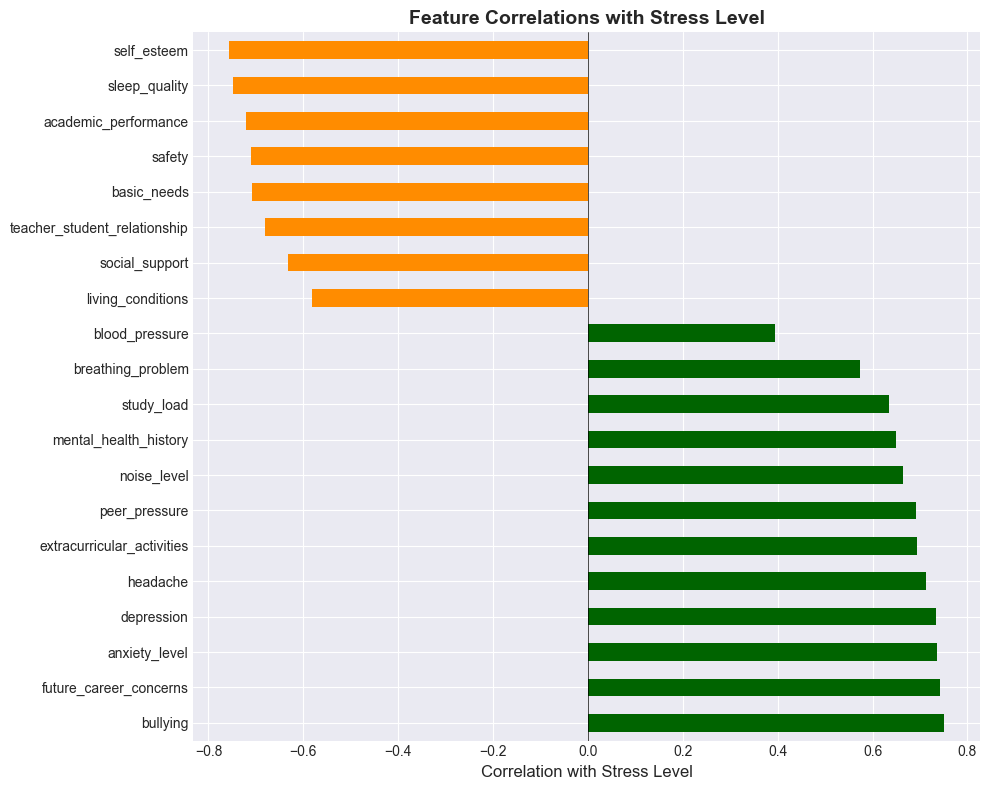

In [15]:
# =============================================================================
# 5. CORRELATION ANALYSIS
# =============================================================================

print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Compute correlation matrix
correlation_matrix = df.corr()

# Create a large heatmap for correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Use a blue-green colormap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='YlGnBu', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(config['output_data']['fig3'], dpi=300, bbox_inches='tight')    # savefig('correlation_matrix.png')
plt.show()

# Top correlations with stress_level
stress_correlations = correlation_matrix['stress_level'].drop('stress_level').sort_values(ascending=False)
print("\nTop 10 Features Correlated with Stress Level:")
print(stress_correlations.head(10))
print("\nBottom 10 Features Correlated with Stress Level:")
print(stress_correlations.tail(10))

# Visualize correlations with stress_level
plt.figure(figsize=(10, 8))
colors = ['darkgreen' if x > 0 else 'darkorange' for x in stress_correlations]
stress_correlations.plot(kind='barh', color=colors)
plt.xlabel('Correlation with Stress Level', fontsize=12)
plt.title('Feature Correlations with Stress Level', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig(config['output_data']['fig4'], dpi=300, bbox_inches='tight')    # savefig('stress_correlations.png')
plt.show()

> **Insight:** Top correlates with stress include **bullying**, **future_career_concerns**, **anxiety_level**, **depression**, and **headache**

In [16]:
# =============================================================================
# 6. MULTICOLLINEARITY DETECTION
# =============================================================================

print("\n" + "=" * 80)
print("MULTICOLLINEARITY DETECTION")
print("=" * 80)

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:  # Threshold of 0.7
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print(high_corr_df)
else:
    print("\nNo highly correlated feature pairs found (threshold: 0.7)")


MULTICOLLINEARITY DETECTION

Highly Correlated Feature Pairs (|correlation| > 0.7):
                 Feature 1               Feature 2  Correlation
16                bullying            stress_level     0.751162
15  future_career_concerns            stress_level     0.742619
3            anxiety_level            stress_level     0.736795
7               depression            stress_level     0.734379
1            anxiety_level  future_career_concerns     0.717016
8                 headache            stress_level     0.713484
14  future_career_concerns                bullying     0.711278
2            anxiety_level                bullying     0.709982
6               depression  future_career_concerns     0.706561
12             basic_needs            stress_level    -0.708968
11                  safety            stress_level    -0.709602
0            anxiety_level           sleep_quality    -0.710292
4              self_esteem  future_career_concerns    -0.712520
13    academic_perf

> **Insight:** For **Multicollinearity Detection** we should ignore correlations with the **target** (stress_level) and only act on **feature–feature** pairs.

- **High-correlation pairs (|r| > 0.7):**
- anxiety_level – future_career_concerns: r = 0.717
- future_career_concerns – bullying: r = 0.711
- anxiety_level – bullying: r = 0.710
- depression – future_career_concerns: r = 0.707
- anxiety_level – sleep_quality: r = −0.710
- self_esteem – future_career_concerns: r = −0.713
- blood_pressure – social_support: r = −0.753

- **We drop:** anxiety_level, future_career_concerns, social_support
- **We keep:** bullying, depression, sleep_quality, self_esteem, blood_pressure

> Removing **anxiety_level** and **future_career_concerns** breaks the dense 0.70+ cluster with **bullying**, **depression**, **sleep_quality**, and **self_esteem**; dropping **social_support** (while keeping **blood_pressure**) resolves the |r|=0.753 pair. This yields a feature set without any remaining |r| > 0.7 **between predictors**. (Correlations with stress_level are expected and were **not** used for dropping; they reflect predictive signal, not multicollinearity.)


BIVARIATE ANALYSIS


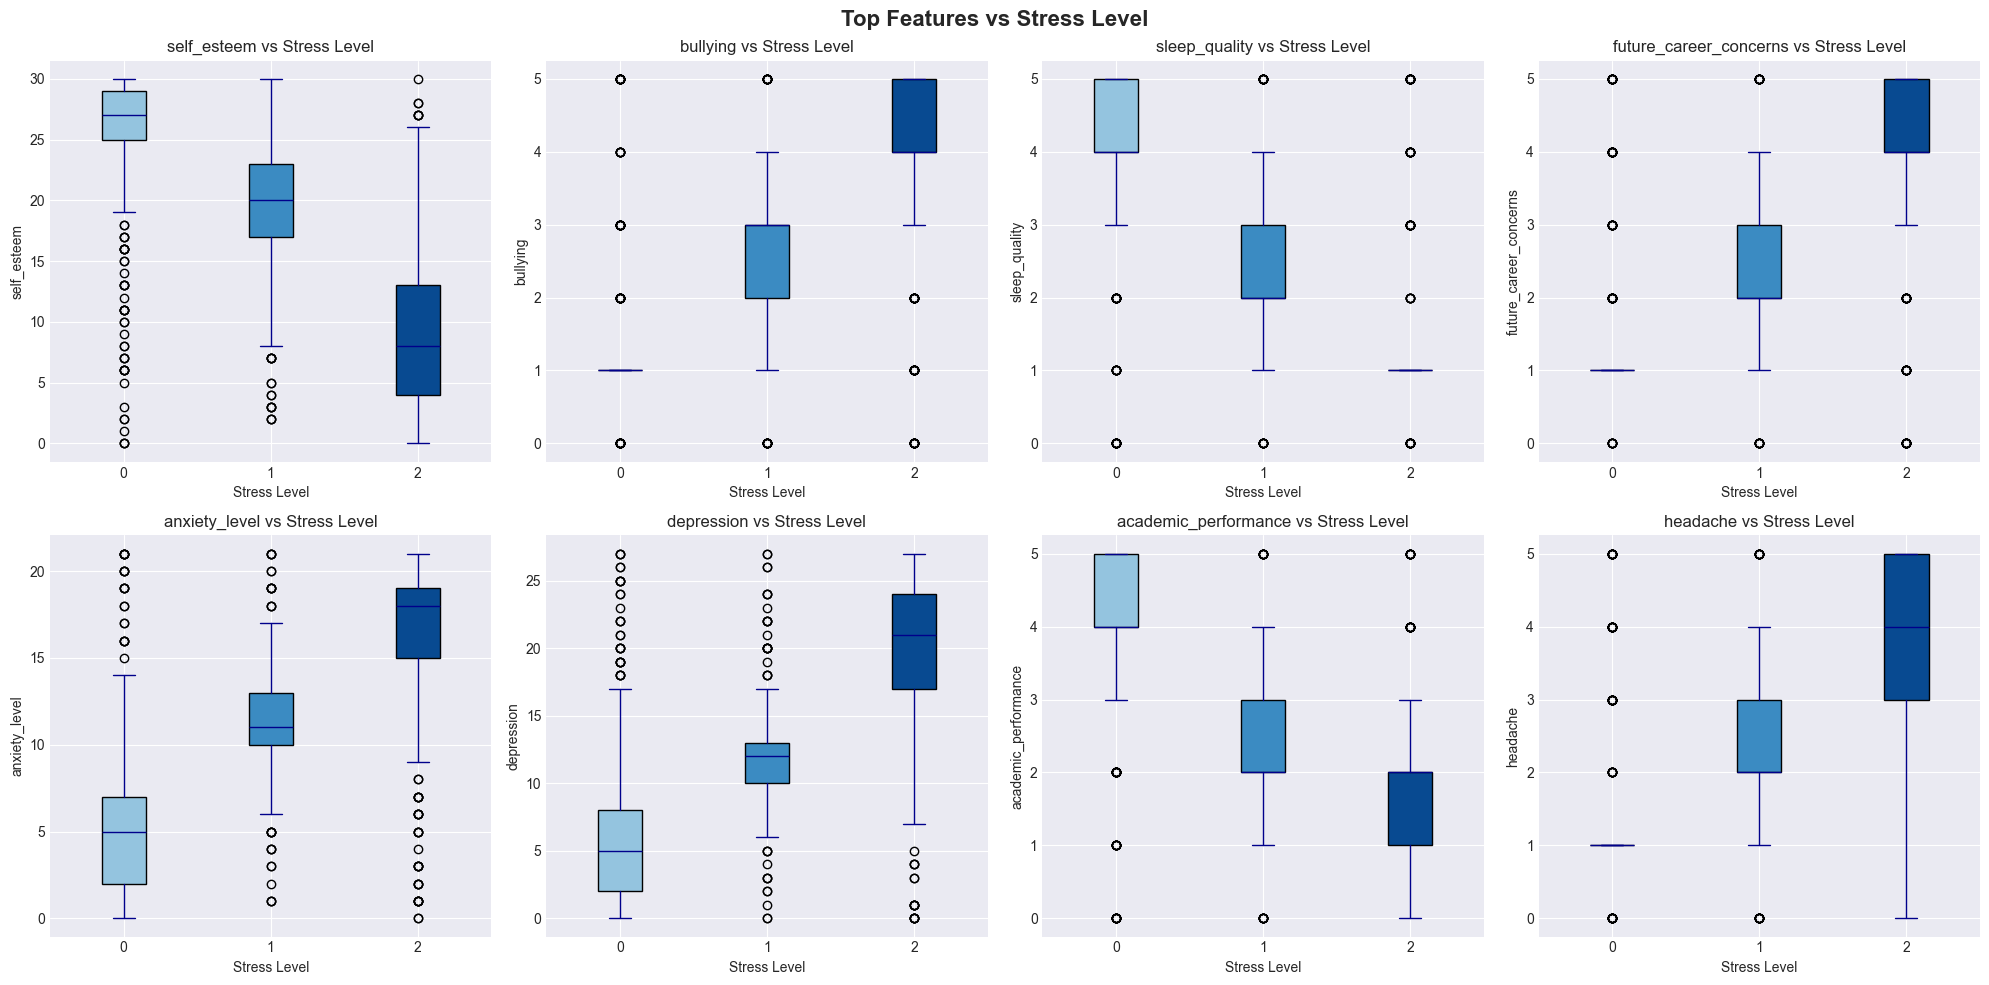

In [17]:
# =============================================================================
# 7. BIVARIATE ANALYSIS - FEATURE VS STRESS LEVEL
# =============================================================================

print("\n" + "=" * 80)
print("BIVARIATE ANALYSIS")
print("=" * 80)

# Select top features based on correlation
top_features = stress_correlations.abs().nlargest(8).index.tolist()

# Create box plots for top features vs stress level
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    # Group data by stress level for the current feature
    data_to_plot = [df[df['stress_level'] == level][feature].values 
                    for level in sorted(df['stress_level'].unique())]
    
    # Create box plot with custom colors
    bp = axes[idx].boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes with a gradient of blues
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(bp['boxes'])))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Customize other elements
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='darkblue')
    
    axes[idx].set_title(f'{feature} vs Stress Level', fontsize=12)
    axes[idx].set_xlabel('Stress Level')
    axes[idx].set_ylabel(feature)
    axes[idx].set_xticklabels(sorted(df['stress_level'].unique()))

plt.suptitle('Top Features vs Stress Level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(config['output_data']['fig5'], dpi=300, bbox_inches='tight')    # savefig('feature_vs_stress_boxplots.png')
plt.show()

> **Insight:** Strongest separation across stress levels for **self_esteem**, **bullying**, **sleep_quality**, **future_career_concerns**, **anxiety_level**, **depression**, **academic_performance**. Directionally (from low to high stress): **bullying**, **future_career_concerns**, **anxiety_level**, and **depression** tend to **increase**, while **self_esteem**, **sleep_quality**, and **academic_performance** tend to **decrease**.


OUTLIER DETECTION

Outlier Summary (IQR Method):
                   count  percentage
noise_level        173.0   15.727273
study_load         165.0   15.000000
living_conditions   62.0    5.636364


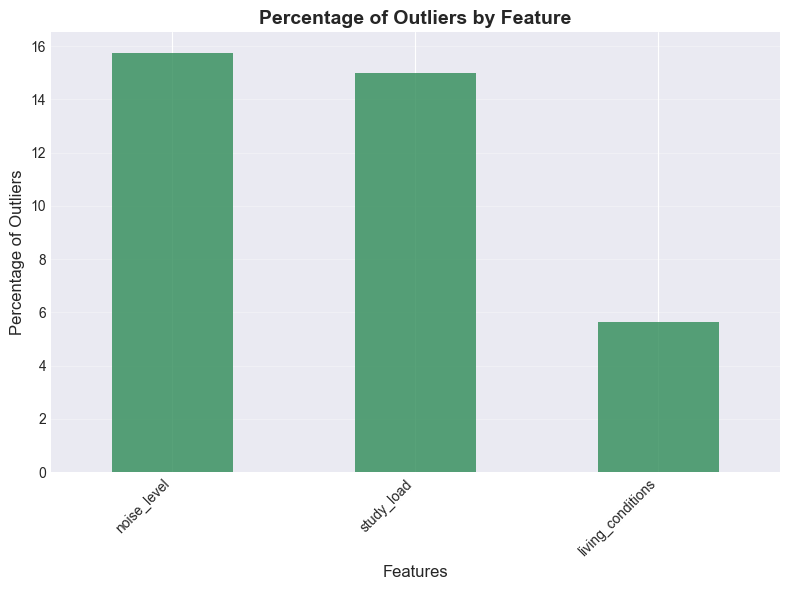

[OUTLIERS] noise_level: outliers=173, low=0.500, high=4.500


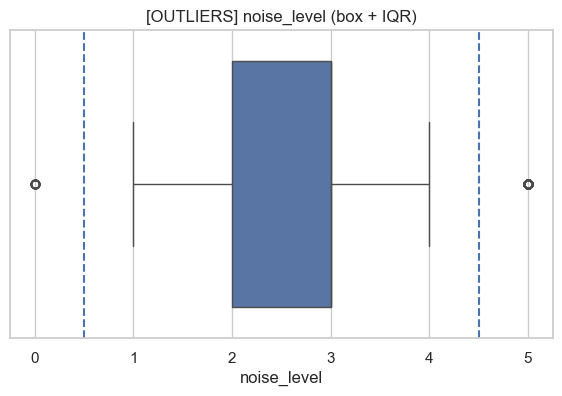

[OUTLIERS] study_load: outliers=165, low=0.500, high=4.500


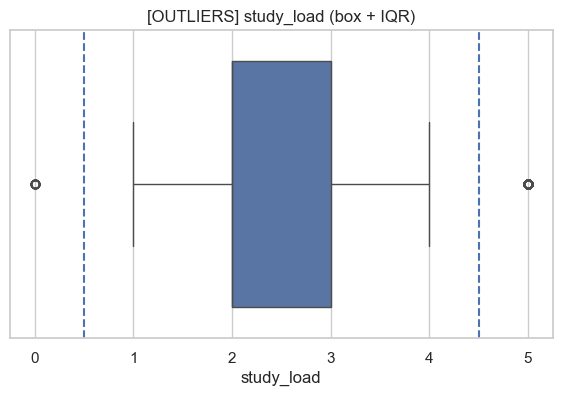

[OUTLIERS] living_conditions: outliers=62, low=0.500, high=4.500


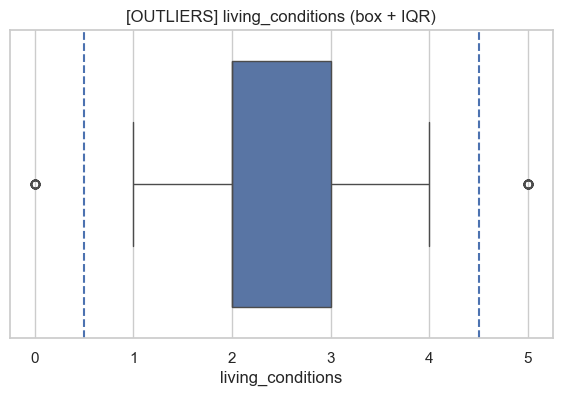

Total rows: 1100 → within IQR limits: 793 | Outliers removed: 307


In [18]:
# =============================================================================
# 8. OUTLIER DETECTION
# =============================================================================

print("\n" + "=" * 80)
print("OUTLIER DETECTION")
print("=" * 80)

# Detect outliers using IQR method
outlier_summary = {}
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(df)) * 100
    }
    
outlier_df = pd.DataFrame(outlier_summary).T
outlier_df = outlier_df.sort_values('count', ascending=False)
print("\nOutlier Summary (IQR Method):")
print(outlier_df[outlier_df['count'] > 0])

# Visualize outliers
plt.figure(figsize=(8, 6))
outlier_df[outlier_df['count'] > 0]['percentage'].plot(kind='bar', color='seagreen', alpha=0.8)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage of Outliers', fontsize=12)
plt.title('Percentage of Outliers by Feature', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(config['output_data']['fig6'], dpi=300, bbox_inches='tight')    # savefig('outlier_percentages.png')
plt.show()

plt.rcParams['figure.figsize'] = (7,4)
sns.set_theme(style="whitegrid")
k: float = 1.5
# Numeric columns to search for outliers
COLS = ['noise_level','study_load','living_conditions']
# Visual scanning and counting
quick_outlier_scan(df, COLS, k, title_prefix="[OUTLIERS] ")

# Quick outliers clean (IQR k=1.5 change to 3.0 less aggressive)
df_no_out, df_out = drop_outliers_iqr(df, COLS, k, how='any')

print(f'Total rows: {df.shape[0]} → within IQR limits: {df_no_out.shape[0]} | Outliers removed: {df_out.shape[0]}')

**Insight:** Three features show > 5% outliers; consider winsorization or robust models/metrics if they degrade performance.


FEATURE IMPORTANCE ANALYSIS

Mutual Information Scores:
                         Feature  MI Score
5                 blood_pressure  0.757233
6                  sleep_quality  0.678559
15        future_career_concerns  0.676649
3                     depression  0.663099
0                  anxiety_level  0.635312
19                      bullying  0.625204
1                    self_esteem  0.601443
4                       headache  0.581823
12          academic_performance  0.547959
14  teacher_student_relationship  0.539078
16                social_support  0.529902
10                        safety  0.524940
11                   basic_needs  0.522586
18    extracurricular_activities  0.519117
17                 peer_pressure  0.495004
8                    noise_level  0.428170
9              living_conditions  0.413704
13                    study_load  0.412941
7              breathing_problem  0.338456
2          mental_health_history  0.243735

Mutual Information Scores:
            

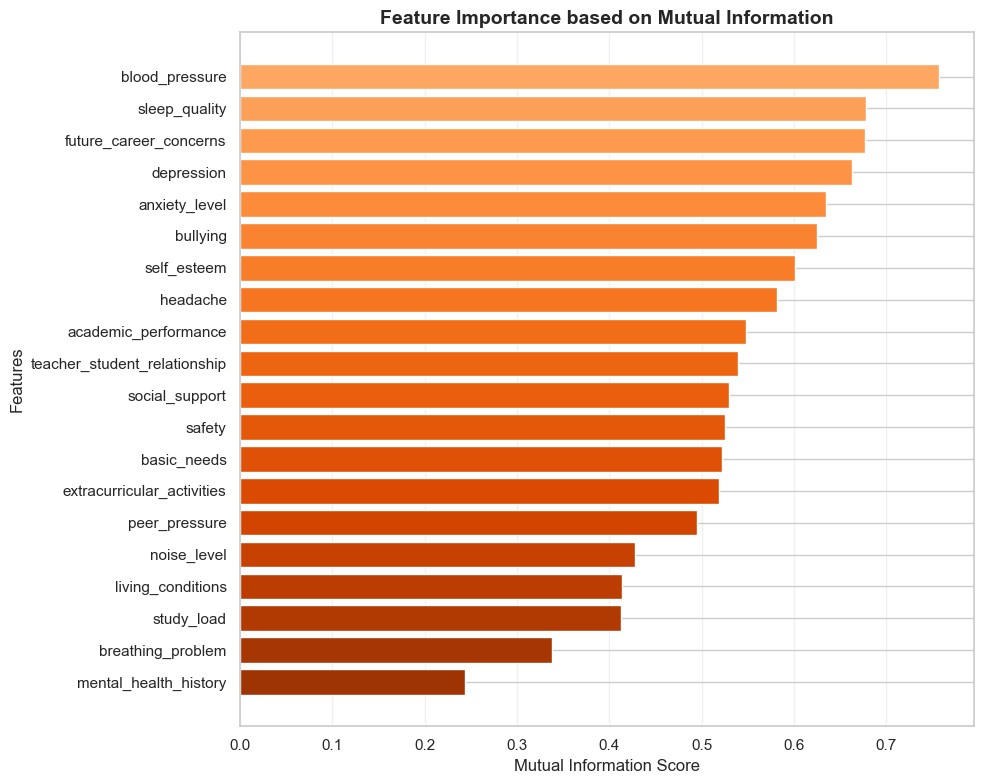

In [19]:
# =============================================================================
# 9. FEATURE IMPORTANCE USING MUTUAL INFORMATION
# =============================================================================

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Calculate mutual information scores
X = df.drop('stress_level', axis=1)
y = df['stress_level']

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

print("\nMutual Information Scores:")
print(mi_scores_df)

# Visualize mutual information scores
plt.figure(figsize=(10, 8))
# Create gradient colors from orange to dark orange
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(mi_scores_df)))
plt.barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color=colors)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance based on Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(config['output_data']['fig7'], dpi=300, bbox_inches='tight')    # savefig('mutual_information_scores.png')
plt.show()

**Insight:** Top Mutual Information features: **blood_pressure**, **sleep_quality**, **future_career_concerns**, **depression**, **anxiety_level** — these carry the most information about stress levels.


DIMENSIONALITY REDUCTION (PCA)


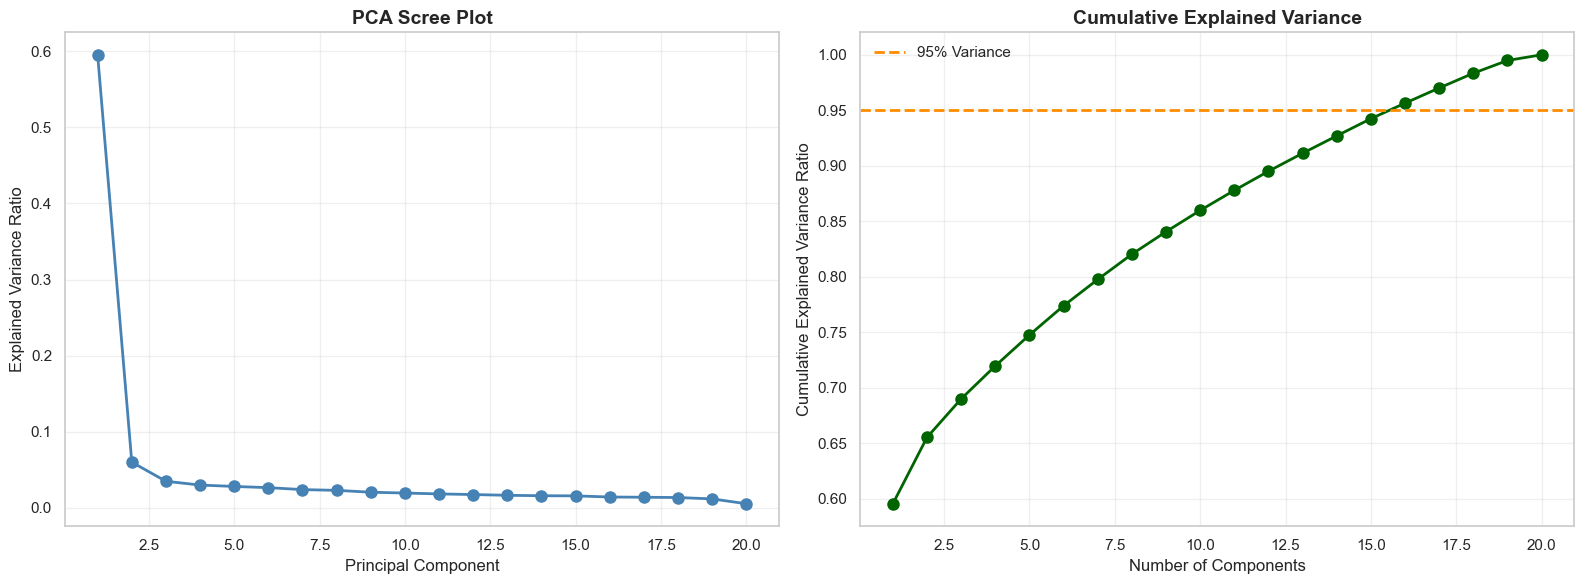


Number of components needed for 95% variance: 16


In [20]:
# =============================================================================
# 10. DIMENSIONALITY REDUCTION VISUALIZATION
# =============================================================================

print("\n" + "=" * 80)
print("DIMENSIONALITY REDUCTION (PCA)")
print("=" * 80)

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', 
         color='steelblue', markersize=8, linewidth=2)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-', 
         color='darkgreen', markersize=8, linewidth=2)
ax2.axhline(y=0.95, color='darkorange', linestyle='--', linewidth=2, label='95% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config['output_data']['fig8'], dpi=300, bbox_inches='tight')    # savefig('pca_analysis.png')
plt.show()

# Number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")


RISK SIGNAL STRENGTH BY FACTOR GROUP


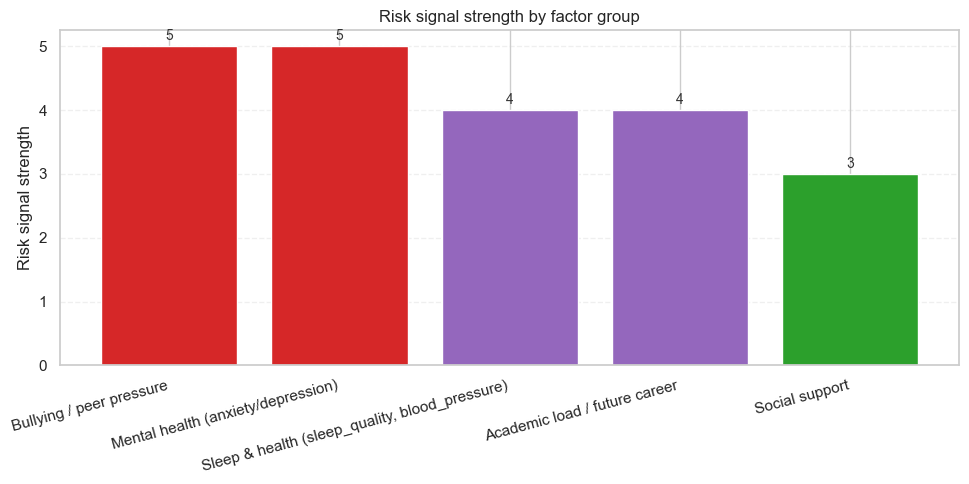

In [21]:
# =============================================================================
# 11. RISK SIGNAL STRENGTH BY FACTOR GROUP
# =============================================================================

print("\n" + "=" * 80)
print("RISK SIGNAL STRENGTH BY FACTOR GROUP")
print("=" * 80)

import matplotlib.pyplot as plt

factor_groups = [
    "Bullying / peer pressure",
    "Mental health (anxiety/depression)",
    "Sleep & health (sleep_quality, blood_pressure)",
    "Academic load / future career",
    "Social support",
]
# keep the relative importance you defined
risk_scores = [5, 5, 4, 4, 3]

plt.figure(figsize=(10, 5))

bars = plt.bar(
    factor_groups,
    risk_scores,
    color=["#d62728", "#d62728", "#9467bd", "#9467bd", "#2ca02c"]
)

plt.ylabel("Risk signal strength")
plt.title("Risk signal strength by factor group")

# rotate x labels so long names are readable
plt.xticks(rotation=15, ha="right")

# add value labels on top of bars
for bar, value in zip(bars, risk_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + 0.05,
        str(value),
        ha="center",
        va="bottom",
        fontsize=10,
        color="#333333"
    )

# light horizontal grid
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig(config['output_data']['fig9'], dpi=300, bbox_inches='tight')    # savefig('risk_signal_strength.png')
plt.show()

**Insight:** About **16 components** explain **95%** of the variance; PCA can be used as an optional step for compact representations. 

In [22]:
# =============================================================================
# 12. STATISTICAL TESTS
# =============================================================================

print("\n" + "=" * 80)
print("STATISTICAL TESTS")
print("=" * 80)

# Test for normality of stress_level
statistic, p_value = stats.normaltest(df['stress_level'])
print(f"\nNormality Test for Stress Level:")
print(f"Statistic: {statistic:.4f}")
# print(f"P-value: {p_value:.4f}")
print(f"P-value: {_pretty_p(p_value)}")
print(f"Is normally distributed? {'Yes' if p_value > 0.05 else 'No'}")

# ANOVA test for categorical-like features vs stress level
print("\nANOVA Tests (Feature groups by stress level):")
for feature in ['anxiety_level', 'self_esteem', 'depression', 'academic_performance']:
    groups = [group[feature].values for name, group in df.groupby('stress_level')]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"\n{feature}:")
    print(f"  F-statistic: {f_stat:.4f}")
    # print(f"  P-value: {p_val:.4f}")
    print(f"  P-value: {_pretty_p(p_val)}")
    print(f"  Significant difference? {'Yes' if p_val < 0.05 else 'No'}")


STATISTICAL TESTS

Normality Test for Stress Level:
Statistic: 7361.7179
P-value: < 0.0001
Is normally distributed? No

ANOVA Tests (Feature groups by stress level):

anxiety_level:
  F-statistic: 655.4532
  P-value: < 0.0001
  Significant difference? Yes

self_esteem:
  F-statistic: 775.3861
  P-value: < 0.0001
  Significant difference? Yes

depression:
  F-statistic: 652.6293
  P-value: < 0.0001
  Significant difference? Yes

academic_performance:
  F-statistic: 639.2229
  P-value: < 0.0001
  Significant difference? Yes


  > **Insight:** ANOVA shows significant mean differences across stress levels for **`anxiety_level` (F = 655.45, p < 0.001), `self_esteem` (F = 775.39, p < 0.001), `depression` (F = 652.63, p < 0.001), and `academic_performance` (F = 639.22, p < 0.001)**. Largest shifts appear between stress **0 vs 2** (confirm via group means/plots). These features are strong candidates for the model and for monitoring class separation.

In [23]:
# =============================================================================
# 13. DROPING COLUMNS AS PER MULTICOLLINEARITY DETECTION
# =============================================================================

# a) Dropping columns from dataframe with no outliers
cols_to_drop = [
    'anxiety_level', 'future_career_concerns', 'social_support'
]
df_no_out = df_no_out.drop(columns=cols_to_drop, errors="ignore")
print("Dropped:", cols_to_drop)
print("New shape:", df_no_out.shape)

# Save file
df_no_out.to_csv(config['output_data']['file1'], index=False, sep=",", encoding="utf-8")

# b) Dropping columns from original dataframe
df = df.drop(columns=cols_to_drop, errors="ignore")
print("Dropped:", cols_to_drop)
print("New shape:", df.shape)

# Save file
df.to_csv(config['output_data']['file2'], index=False, sep=",", encoding="utf-8") 

Dropped: ['anxiety_level', 'future_career_concerns', 'social_support']
New shape: (793, 18)
Dropped: ['anxiety_level', 'future_career_concerns', 'social_support']
New shape: (1100, 18)


In [24]:
# =============================================================================
# 14. DATA PREPROCESSING RECOMMENDATIONS
# =============================================================================

print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR ML PREPROCESSING")
print("=" * 80)

print("\n1. FEATURE SCALING:")
print("   - All features are on similar scales (mostly 0-5 range)")
print("   - StandardScaler or MinMaxScaler recommended for algorithms sensitive to scale")
print("   - Tree-based models may not require scaling")

print("\n2. HANDLING MULTICOLLINEARITY:")
if high_corr_pairs:
    print("   - Consider removing one feature from highly correlated pairs")
    print("   - Or use dimensionality reduction techniques (PCA, LDA)")
else:
    print("   - No severe multicollinearity detected")

print("\n3. OUTLIER TREATMENT:")
if outlier_df[outlier_df['count'] > 0].shape[0] > 0:
    print("   - Consider capping outliers or using robust scaling")
    print("   - Tree-based models are generally robust to outliers")
else:
    print("   - Minimal outliers detected")

print("\n4. FEATURE ENGINEERING SUGGESTIONS:")
print("   - Create interaction features between highly correlated variables")
print("   - Consider polynomial features for non-linear relationships")
print("   - Group similar features (e.g., physical symptoms, academic factors)")

print("\n5. CLASS IMBALANCE:")
stress_dist = df['stress_level'].value_counts(normalize=True)
if stress_dist.min() < 0.1:
    print("   - Consider using SMOTE or class weights for imbalanced classes")
else:
    print("   - Classes are reasonably balanced")

print("\n6. FEATURE SELECTION:")
print("   - Use mutual information scores for initial feature selection")
print("   - Consider recursive feature elimination with cross-validation")
print(f"   - Start with top {len(mi_scores_df[mi_scores_df['MI Score'] > 0.1])} features based on MI scores")


RECOMMENDATIONS FOR ML PREPROCESSING

1. FEATURE SCALING:
   - All features are on similar scales (mostly 0-5 range)
   - StandardScaler or MinMaxScaler recommended for algorithms sensitive to scale
   - Tree-based models may not require scaling

2. HANDLING MULTICOLLINEARITY:
   - Consider removing one feature from highly correlated pairs
   - Or use dimensionality reduction techniques (PCA, LDA)

3. OUTLIER TREATMENT:
   - Consider capping outliers or using robust scaling
   - Tree-based models are generally robust to outliers

4. FEATURE ENGINEERING SUGGESTIONS:
   - Create interaction features between highly correlated variables
   - Consider polynomial features for non-linear relationships
   - Group similar features (e.g., physical symptoms, academic factors)

5. CLASS IMBALANCE:
   - Classes are reasonably balanced

6. FEATURE SELECTION:
   - Use mutual information scores for initial feature selection
   - Consider recursive feature elimination with cross-validation
   - Start 

In [25]:
# =============================================================================
# 15. SAVE ANALYSIS SUMMARY
# =============================================================================

# Create a summary report
summary_report = f"""
STRESS LEVEL DATASET ANALYSIS SUMMARY
=====================================

Dataset Overview:
- Total Records: {df.shape[0]}
- Total Features: {df.shape[1]}
- No Missing Values: {missing_values.sum() == 0}
- Duplicate Rows: {duplicates}

Target Variable Distribution:
{stress_counts.to_dict()}

Top 5 Features Correlated with Stress Level:
{stress_correlations.head(5).to_dict()}

Feature Importance (Top 5 by Mutual Information):
{mi_scores_df.head(5).to_dict()}

Dimensionality Reduction:
- Components for 95% variance: {n_components_95}

Outliers Detected:
- Features with >5% outliers: {len(outlier_df[outlier_df['percentage'] > 5])}

Preprocessing Recommendations:
1. Scaling: Recommended (StandardScaler/MinMaxScaler)
2. Feature Selection: Start with top {len(mi_scores_df[mi_scores_df['MI Score'] > 0.1])} features
3. Handle multicollinearity if needed
4. Consider ensemble methods for robustness
"""

# Save summary to file
with open('analysis_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nFiles saved:")
print("- feature_distributions.png")
print("- stress_level_distribution.png")
print("- correlation_matrix.png")
print("- stress_correlations.png")
print("- feature_vs_stress_boxplots.png")
print("- outlier_percentages.png")
print("- mutual_information_scores.png")
print("- pca_analysis.png")
print("- analysis_summary.txt")
print("\nReady for ML modeling!")


ANALYSIS COMPLETE!

Files saved:
- feature_distributions.png
- stress_level_distribution.png
- correlation_matrix.png
- stress_correlations.png
- feature_vs_stress_boxplots.png
- outlier_percentages.png
- mutual_information_scores.png
- pca_analysis.png
- analysis_summary.txt

Ready for ML modeling!
